### Nacachian Mauro -- 99619
## Simulacion Monte Carlo para ambos tipos de repetidores

Se simula el sistema analogico y digital para 9 etapas y para 5 a 25 dB. Se usan 1000 muestras 

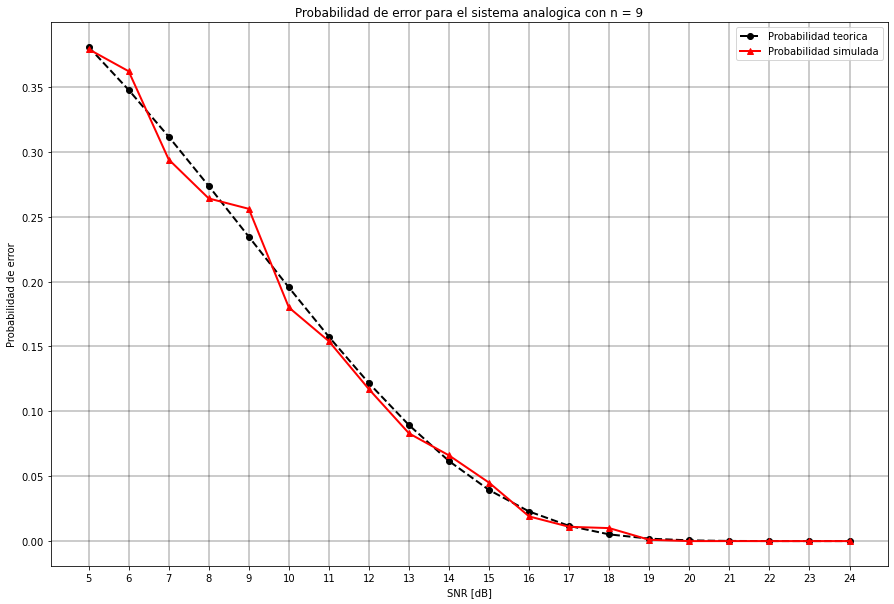

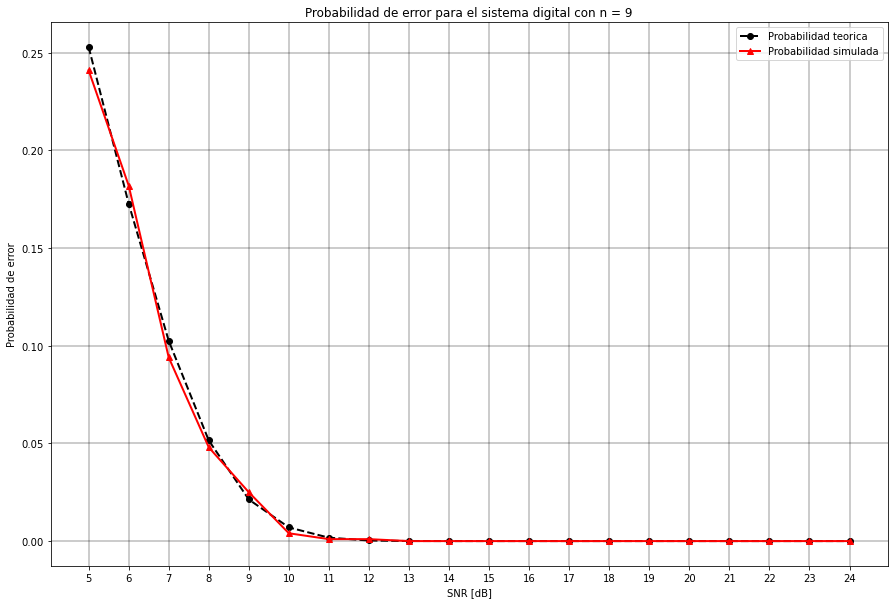

In [3]:

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from copy import copy

# Funcion indicador para el sistema analogico
# devuelve 1 si el simbolo recibido es distinto a lo recibido
# usando la toma de decision en la utlima etapa
#
def etapaDecision(x,yn):
    if x > 0 and yn < 0:
        return 1
    if x < 0 and yn >= 0:
        return 1
    else:
        return 0

def monteCarloDig(xn, x1, k):
    sum = 0 
    for i in range(k):
        if xn[i] != x1[i]:
            sum = sum + 1
    return sum/k
            
def monteCarloAnalog(yn, x1, k):
    sum = 0
    for i in range(k):
        sum = sum + etapaDecision(x1[i], yn[i])
    return sum/k


def probErrorAnalog(snr,n):
    return stats.norm.sf(np.sqrt( 1 / (pow((snr+1) / snr,n) - 1) ))

def probErrorDigital(snr,n):
    return (1- pow((1 - 2 * stats.norm.sf( np.sqrt(snr) ) ), n) ) / 2


muestras = 1000 ## cantidad de realizaciones

n = 9 ## cantidad de etapas
h = 1
A = 1
snr_db = np.arange(5,25,1) # en dB
snr = 10**((snr_db)/10)

pErrorAnalog = []
pErrorDig = []

for k in range(np.size(snr_db)):
    sigma = pow(h, 2) * pow(A, 2) / snr[k]
    Wi = np.random.randn(muestras, n) * np.sqrt(sigma)  
    X1 = np.random.choice([A, -A], muestras, p = [0.5, 0.5])
    
    #######################
    ## Sistema Analogico ##
    #######################
    
    G = np.sqrt(snr[k] / (snr[k] + 1)) / h
    ruido = []
    for j in range(muestras):
        aux = 0
        for i in range(n):
            aux = aux + Wi[j][i] * pow(G,n-(i+1)) * pow(h,n-(i+1))
        ruido.append(aux)
    Yn = []
    for i in range(muestras):
        Yn = np.append(Yn,pow(G,n-1) * pow(h,n) * X1[i] + ruido[i])

    
    pErrorAnalog = np.append(pErrorAnalog, monteCarloAnalog(Yn, X1, muestras))
    
    #####################
    ## Sistema Digital ##
    #####################
    
    #W = np.random.randn(muestras, n) * np.sqrt(sigma)  
    Ynd = X1 * h + Wi[:,0] # Accedo a las realizaciones de la primer etapa
    Xn = copy(X1)
    
    for i in range(muestras):
        for j in range(n):
            Ynd[i] = Xn[i] * h + Wi[i][j]
            # Toma de decision #
            if Ynd[i] < 0:
                Xn[i] = -A
            else:
                Xn[i] = A
    
    pErrorDig = np.append(pErrorDig, monteCarloDig(Xn, X1, muestras))
           

# Probabilidades por formula
#
pErrorDigTeorica = probErrorDigital(snr, n)            
pErrorAnalogTeorica = probErrorAnalog(snr, n)

# Graficos comparativos para n = 9
#
plt.figure(figsize = (15,10))
plt.plot(snr_db, pErrorAnalogTeorica, '--o', label = 'Probabilidad teorica', color = 'black', linewidth = 2)
plt.plot(snr_db, pErrorAnalog, '-^', label = 'Probabilidad simulada', color = 'red', linewidth = 2)
#plt.yscale('log')
plt.legend()
plt.xticks(snr_db)
plt.xlabel('SNR [dB]')
plt.ylabel('Probabilidad de error')
plt.grid(b = True, which = 'major', color = 'black', linestyle = '-', linewidth = 0.4)
plt.grid(b = True, which = 'minor', color = 'black', linestyle = '-', linewidth = 0.4)
plt.legend(loc = 'best')
plt.title('Probabilidad de error para el sistema analogica con n = 9')
plt.savefig("comparativa_analog_sim.png")

plt.figure(figsize = (15,10))
plt.plot(snr_db, pErrorDigTeorica, '--o', label = 'Probabilidad teorica', color = 'black', linewidth = 2)
plt.plot(snr_db, pErrorDig, '-^' ,label = 'Probabilidad simulada', color = 'red', linewidth = 2)
#plt.yscale('log')
plt.legend()
plt.xticks(snr_db)
plt.xlabel('SNR [dB]')
plt.ylabel('Probabilidad de error')
plt.grid(b = True, which = 'major', color = 'black', linestyle = '-', linewidth = 0.4)
plt.grid(b = True, which = 'minor', color = 'black', linestyle = '-', linewidth = 0.4)
plt.legend(loc = 'best')
plt.title('Probabilidad de error para el sistema digital con n = 9')
plt.savefig("comparativa_dig_sim.png")
